### Dimension Reduction Analysis

First run at the combination of embeddings into 2d space for easy visualization. 

* Single dataset (using common API to be easily swapped for any other choice of dataset)
* Group of algorithms
* Analysis of how the algorithms performed vs. each other
    * Visualization of the low dimensional space
    * Comparison via various quality measures
    

In [1]:
import sklearn.datasets as datasets
from sklearn.metrics import pairwise_distances

import src
from src.visualization.plotting import two_dim_multiplot
from src.visualization.plotting import two_dim_label_viz
import src.quality_measures as qm

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

from math import ceil

In [2]:
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import logging
import time

# Timing and Performance

LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
DATE_FORMAT = "%m/%d/%Y %I:%M:%S %p"

logging.basicConfig(format=LOG_FORMAT, datefmt=DATE_FORMAT, level=logging.INFO) 
logger = logging.getLogger()

### Notebook has built in message handling
# message_handler = logging.StreamHandler(sys.stdout)
# info level logging already in notebook
# message_handler.setLevel(logging.INFO)
# message_handler.setFormatter(logging.Formatter(LOG_FORMAT))
# logger.addHandler(message_handler)

def timing_info(method):
    def wrapper(*args, **kw):
        start_time = time.time()
        result = method(*args, **kw)
        end_time = time.time()
        logger.info("timing_info: {}@{} ms".format(method.__name__, round((end_time-start_time)*1000,1)))
        return result

    return wrapper

def record_time_interval(section, start_time, line_break=False):
    """Record a time interval since the last timestamp"""
    end_time = time.time()
    delta = end_time - start_time
    if delta < 1:
        delta *= 1000
        units = "ms"
    else:
        units = "s"
    if line_break:
        logger.info("PROCESS_TIME:{:>36}    {} {}\n".format(section, round(delta, 1), units))
    else:
        logger.info("PROCESS_TIME:{:>36}    {} {}".format(section, round(delta, 1), units))
    return end_time

In [5]:
## To replace with data from the data directory
## Use small sample of MNIST included in sklearn for the interim

In [6]:
dataset = src.data.datasets.load_dataset('coil-20')
dataset_name = 'COIL-20'
metric = 'euclidean'

print(dataset.DESCR)

Columbia University Image Library (COIL-20)

Notes
-----
Data Set Characteristics:
    :Number of Instances: 1440
    :Number of Attributes: 49152
    :Attribute Information: 128x128 8-bit greyscale (PGM) image
    :Missing Attribute Values: None
    :Creator: Sameer A Nene, Shree K. Nayar and Hiroshi Murase
    :Date: 1995

This is a copy of the Columbia Object Image Library [COIL-20] data:
http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.tar.gz

This dataset consists of 1,440 greyscale images of 20 objects (72 images per object) where the objects
have been placed on a motorized turntable against a black background. Images were taken at 5 degree rotations,
giving 72 images per object. The resulting images were then size and intensity-normalized.

Size normalization involved first clipping to a rectangual bounding box and resized (with aspect
ratio preserved) to 128x128 using interpolation-decimation filters to minimize aliasing [Oppenheim and Schafe

In [7]:
high_data = dataset.data
labels = dataset.target

## Choice of algorithms to use

Have them all set to use sklearn style API

* PCA
* MDS
* Isomap
* TSNE

TODO: Include other algorithms that we're going to compare here

In [8]:
low_dimension = 2

In [9]:
algorithms = {'PCA' : PCA(n_components=low_dimension, svd_solver='arpack'),
              'MDS' : MDS(n_components=low_dimension, metric=True),
              'Isomap' : Isomap(n_components=low_dimension),
              'tSNE' : TSNE(n_components=low_dimension)}

The next step takes approximately 
* Small MNIST: 2 minutes
* COIL-20: 8 minutes

In [10]:
low_data = {}
ts = time.time()
for name, algorithm in algorithms.items():
    logger.info(f"Starting {name}")
    low_data[name] = algorithm.fit_transform(high_data)
    ts = record_time_interval(name, ts)

INFO 06/30/2018 08:19:45 PM - Starting PCA
INFO 06/30/2018 08:19:49 PM - PROCESS_TIME:                                 PCA    4.5 s
INFO 06/30/2018 08:19:49 PM - Starting MDS
INFO 06/30/2018 08:22:02 PM - PROCESS_TIME:                                 MDS    133.0 s
INFO 06/30/2018 08:22:02 PM - Starting Isomap
INFO 06/30/2018 08:25:16 PM - PROCESS_TIME:                              Isomap    193.6 s
INFO 06/30/2018 08:25:16 PM - Starting tSNE
INFO 06/30/2018 08:29:11 PM - PROCESS_TIME:                                tSNE    235.2 s


## TODO: Save embeddings and only run algorithms if the parameters (including algorithm name) are different than what already exists

## Visualization of the Embeddings

In [11]:
data = []
labels_list = [labels] * len(low_data)
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(k)

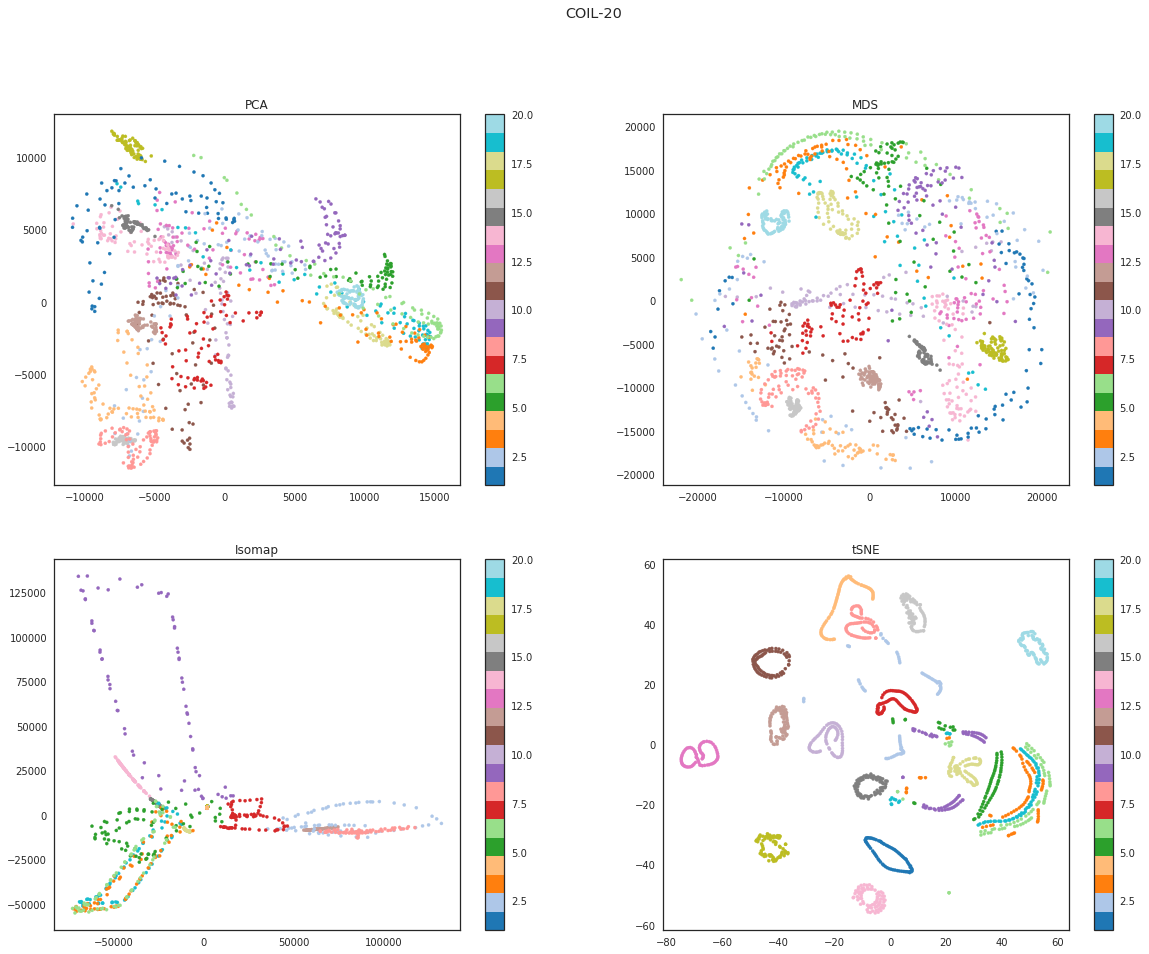

In [12]:
sns.set(style='white', rc={'figure.figsize':(20,15)})
two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="tab20", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Analysis via quality scores

Start by getting pairwise distances needed for both Stress and Strain.

In [13]:
high_distances = pairwise_distances(high_data, metric=metric)

In [14]:
%%time
low_distances_dict = {}
for name, data in low_data.items():
    _, low_distances, _ = qm.pairwise_distance_differences(high_distances=high_distances,
                                                           low_data=data, metric=metric)
    low_distances_dict[name] = low_distances

CPU times: user 133 ms, sys: 311 ms, total: 444 ms
Wall time: 115 ms


### Strain from Classical MDS
Strain is the name given to stress that is optimized in classical MDS. The optimal solution is given by PCA.

$$\textstyle Strain_{D}(x_{1},x_{2},...,x_{N})={\Biggl (}{\frac {\sum _{i,j}{\bigl (}b_{ij}-\langle x_{i},x_{j}\rangle {\bigr )}^{2}}{\sum _{i,j}b_{ij}^{2}}}{\Biggr )}^{1/2}$$

where $B = -\frac{1}{2} J D^{(2)}J$ and $J = I_{N}-{\tfrac  {1}{N}}{\mathbf  {1}}{\mathbf  {1}}^{\top }$ where $\mathbf  {1}$ is the $N$-dimensional vector of 1's. 

#### Note: Only need to change the following to cells to get the analysis using a different quality score

In [15]:
score = 'Strain'

In [16]:
%%time
point_score = {}
total_score = {}
for name, low_distances in low_distances_dict.items():
    point_score[name] = qm.point_strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)
    total_score[name] = qm.strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)

CPU times: user 4.58 s, sys: 2.08 s, total: 6.66 s
Wall time: 1.74 s


### Visualization of the point score on the same scale
Color represents the value of the contribution of a given point towards the total score

In [17]:
data = []
labels_list = []
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(f"{k}\n {score}: {total_score[k]}")
    labels_list.append(point_score[k])

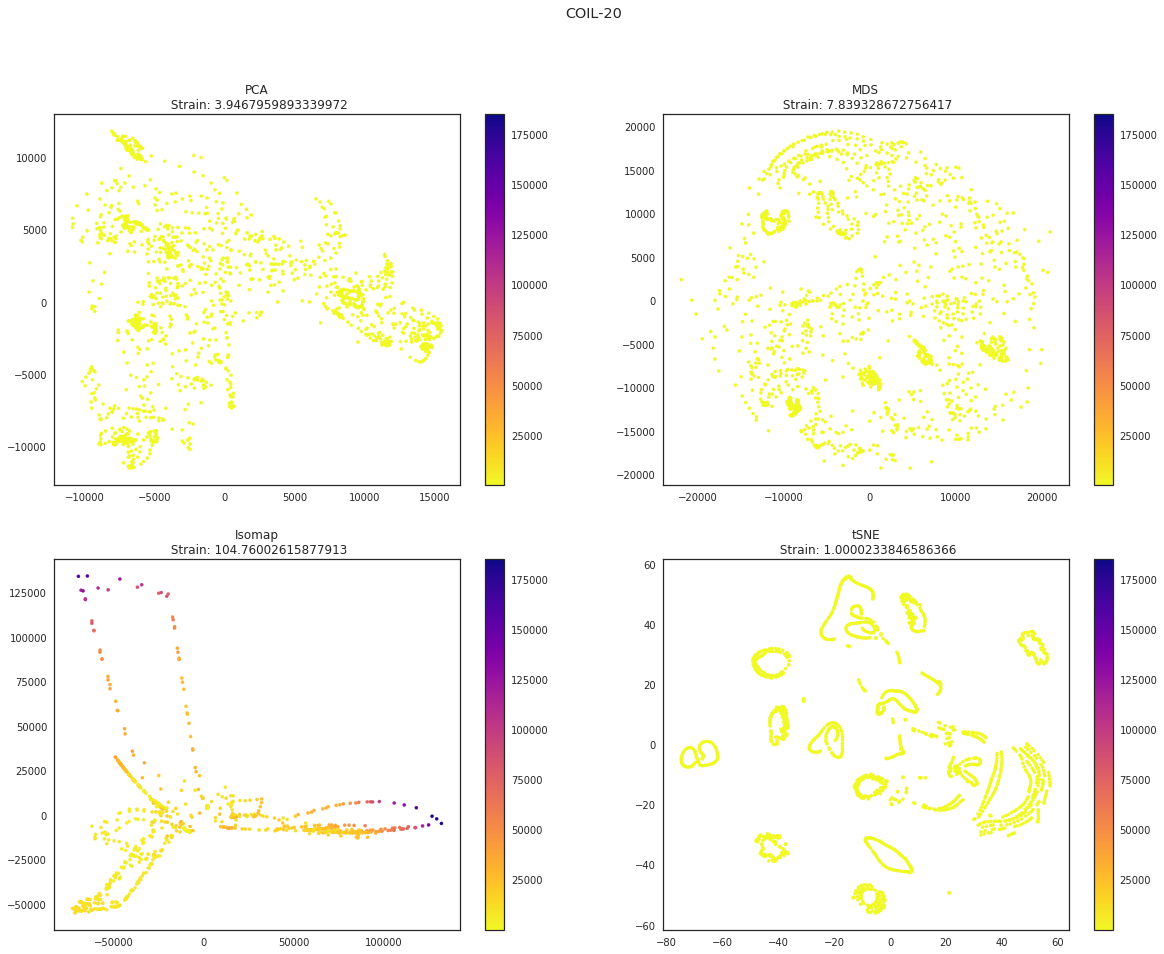

In [18]:
sns.set(style='white', rc={'figure.figsize':(20,15)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=True)
plt.suptitle(dataset_name);

### How about distributions

In [19]:
point_score_df = pd.DataFrame(point_score)

In [20]:
point_score_df.describe()

,PCA,MDS,Isomap,tSNE
count,1440.000000,1440.000000,1440.000000,1440.000000
mean,15.515096,70.881434,13701.798925,1.000048
std,3.206888,34.923103,19408.714097,0.000026
min,8.039995,31.399213,1889.004441,0.999952
25%,13.256844,48.222030,4063.206079,1.000033
50%,15.523926,58.571444,7355.037826,1.000045
75%,17.829600,81.735743,16494.468353,1.000060
max,30.230063,294.389871,184917.344089,1.000158


/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg

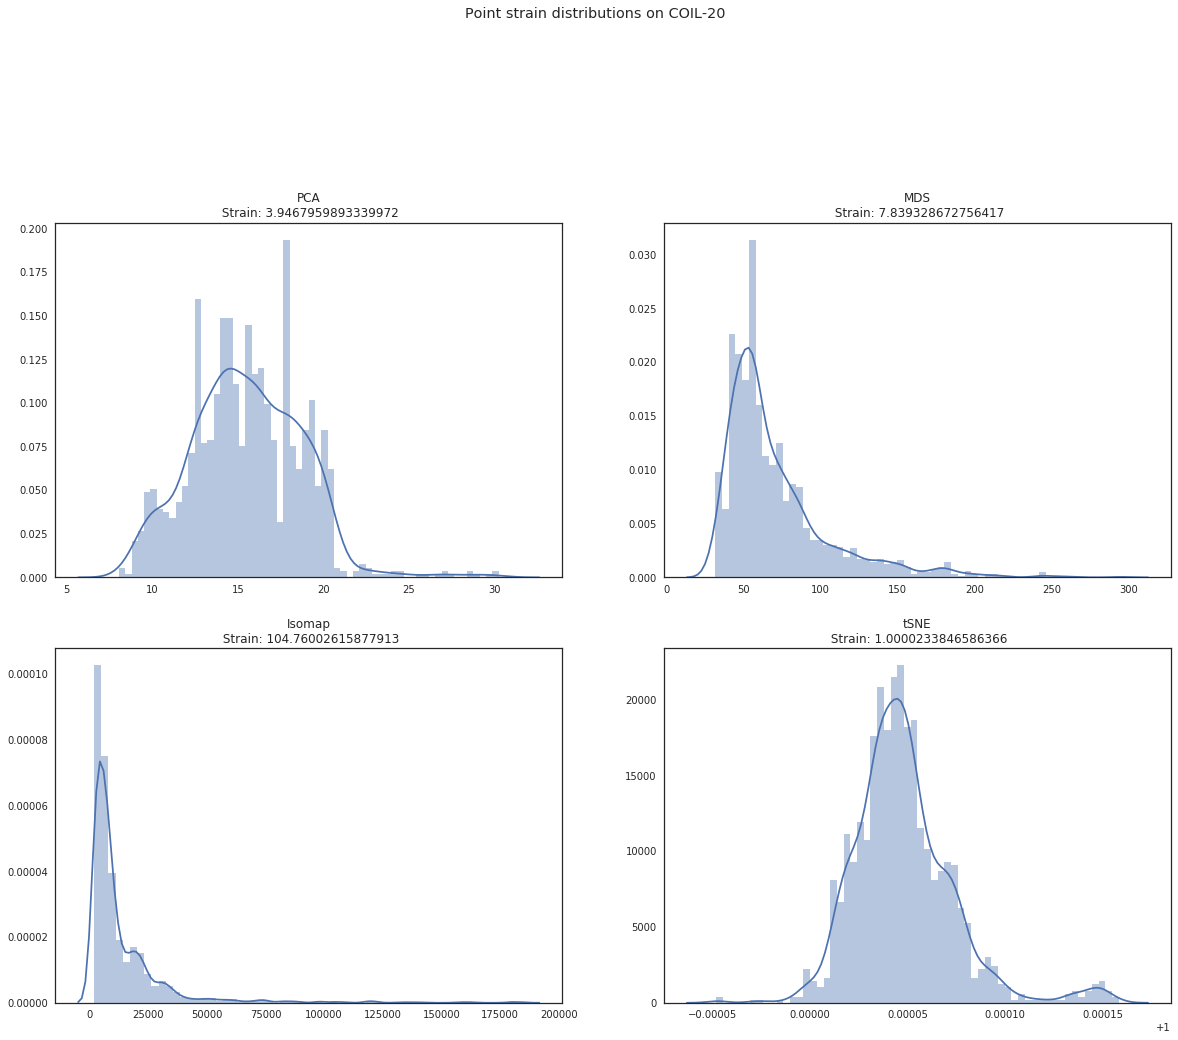

In [21]:
sns.set(style='white', rc={'figure.figsize':(20,30)})

plot_num = 1
ncols = 2
nrows = ceil(len(point_score))

for name, p_score in point_score.items():
    plt.subplot(nrows, ncols, plot_num)
    plot_num += 1
    plt.title(f"{name}\n {score}: {total_score[name]}")
    sns.distplot(p_score, bins=60)
plt.suptitle(f"Point {score.lower()} distributions on {dataset_name}");

### With different colorbar scales

Here we can see where the distrubutions lie with respect to the reduction

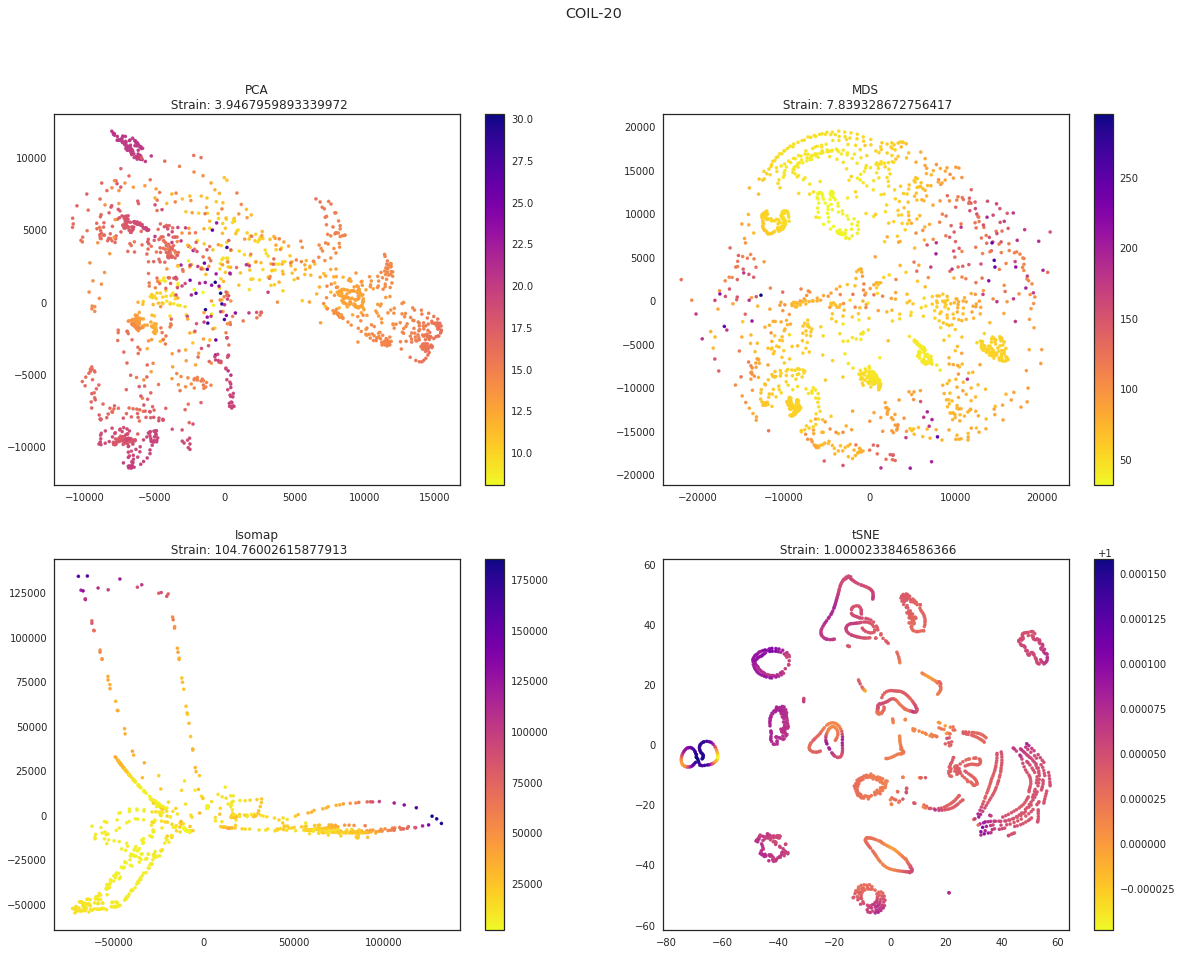

In [22]:
sns.set(style='white', rc={'figure.figsize':(20,15)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Are the same points contributing to the high values in all cases?

In [23]:
n_worst_points = 100

In [24]:
worst_scoring_points = {}
for name, p_score in point_score.items():
    a = point_score_df[name]
    worst_scoring_points[name] = np.argpartition(a, -1 * n_worst_points)[-1 * n_worst_points:]

In [25]:
shared_points_idx = set(point_score_df.index)
for name, worst_points in worst_scoring_points.items():
    shared_points_idx.intersection_update(worst_points)
shared_points_idx = list(shared_points_idx)
len(shared_points_idx)

0

In [26]:
point_score_df.iloc[shared_points_idx]

,PCA,MDS,Isomap,tSNE


In [27]:
# Note that there is overlap if we take stress instead of strain